# Chapter 4. Building Good Training Sets - Data Preprocessing
https://www.amazon.co.jp/Python-Machine-Learning-Cutting-edge-Predictive/dp/1783555130

まずは利用するPython, packageのバージョンを確認する。

In [1]:
from sys import version
print("Python (>=3.4.3) :", version)

import numpy as np
print("numpy (>=1.9.1):", np.__version__)

import pandas as pd
print("pandas (>=0.15.2):", pd.__version__)

import sklearn
print("sklearn (>=0.15.2):", sklearn.__version__)

import matplotlib as mpl
print("sklearn (>=1.4.0):", mpl.__version__)

# scipy required >=0.14.0

Python (>=3.4.3) : 3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]
numpy (>=1.9.1): 1.12.0
pandas (>=0.15.2): 0.19.2
sklearn (>=0.15.2): 0.18.1
sklearn (>=1.4.0): 2.0.0


## Dealing with Missing Data

In [2]:
# Prepare dataset in DataFrame
from io import StringIO # https://docs.python.jp/3/library/io.html#io.StringIO

csv_data = '''A,B,C,D
               1.0,  2.0,  3.0, 4.0
               5.0,  6.0,, 8.0
              10.0, 11.0, 12.0,
              '''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
A    3 non-null float64
B    3 non-null float64
C    2 non-null float64
D    2 non-null float64
dtypes: float64(4)
memory usage: 176.0 bytes


In [4]:
df.isnull()

,A,B,C,D
0,False,False,False,False
1,False,False,True,False
2,False,False,False,True


In [5]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [6]:
# Convert to numpy array
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

### Eliminating Samples or Features with Missing Data

In [7]:
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# Drop rows that have NaN.
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# Drop columns that have NaN.
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [10]:
# Drop rows where all data is NaN .
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [11]:
# Drop rows that have <4 non-NaN values.
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [12]:
# Drop rows where NaN appears in column "C".
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### Imputing Missing Values
欠損値を補完する。以下はデータの再確認。

In [13]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

scikit-learn の Imputer を利用する。以下はオプションに strategy='mean', axis=0 を指定して行ごとに平均を計算して補完した。strategy オプションは他に'median' や 'most_frequent' をとれる。列ごとに計算して補完する場合は axis=1 と指定する。

In [14]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

### Understanding the scikit-learn Estimator API
Transformer クラスの流れは下図左で、データに何かしらの変換を施すために、fit メソッド、transform メソッドがメインに使われる。fit メソッドは Training Data を入力にして transformer モデルのパラメタを学習する。transform メソッドは fit メソッドで学習したパラメタを使用して Training Data もしくは Test Data を実際に変換する。

Estimator (クラス?)の流れは下図右で、 新しいデータから答えを予測するために、fit メソッド、predict メソッドがメインに使われる。fit メソッドは X_train および y_train を入力にして教師付き学習モデルのパラメタを学習する。predict メソッドは、fit メソッドでパラメタの学習をしたモデルを使用して、答えの分かっていないTest Dataを入力にして predict メソッドで未知の答えを予測する。transform メソッドも存在するが後の章で言及する。

<img src=picture/Ch_4_class_workflow.png width="900px">


## Handling Categorical Data

In [15]:
# Prepare dataset in DataFrame
df = pd.DataFrame([
                    ["green", "M", 10.1, "class1"],
                    ["red",   "L", 13.5, "class2"],
                    ["blue", "XL", 15.3, "class1"]
                    ])
df.columns = ["color", "size", "price", "classlabel"]
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Mapping Ordinal Features
辞書型でマップする単語・変数を定義する。以下では "size" フィールドのデータが M から 1 に、 L から 2 に、 XL から 3 に変換された。

In [16]:
# Map categorical words to numbers
size_mapping = {"M":1, "L":2, "XL":3}
df["size"] = df["size"].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


もとに戻す場合は変換に使用した辞書型変数の key と item を入れ替えた辞書型変数を定義してマップする。

In [17]:
inv_size_mapping = {v:k for k, v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

In [18]:
size_mapping

{'L': 2, 'M': 1, 'XL': 3}

### Encoding Class Labels
サイズのマッピングと同様に、辞書型変数を定義しマップする。

In [19]:
class_mapping = {label:idx for idx, label in enumerate(np.unique(df.classlabel))}
class_mapping

{'class1': 0, 'class2': 1}

In [20]:
df.classlabel = df.classlabel.map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


もとに戻すにはサイズのマッピングと同様に、辞書型変数の key と item を入れ替えた辞書型変数を利用する。

In [21]:
# Inverse the classlabels
inv_class_mapping = {v:k for k, v in class_mapping.items()}
df.classlabel = df.classlabel.map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


LabelEncoderクラスを使用する方法もある。

In [22]:
# Convert classlabels in another way with LabelEncoder
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df.classlabel.values)
y

array([0, 1, 0], dtype=int64)

In [23]:
# Inverse the classlabels
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### Performing One-Hot Encoding on Nominal Features
One-Hot encoder という方法も利用できる。1-of-K 法の実装に相当する。以下は上と同様にLabelEncoderによる符号化を表している。
この方法は size 属性同様に、 color 属性を整数に置き換えて符号化するが、本来は大小関係が無いにもかかわらず red > green > blue という認識をしてしまう。学習結果は収束はするが、最適解ではない可能性が高い。そこで次元数を増やして0 or 1のみで符号化表現をする。

In [24]:
X = df[["color", "size", "price"]].values
X

array([['green', 1, 10.1],
       ['red', 2, 13.5],
       ['blue', 3, 15.3]], dtype=object)

In [25]:
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

ここからが本番。1つ目の方法は scikit-learn の OneHotEncoder クラスを利用すること。以下のように符号化している。
- "green": [0, 1, 0]
- "red":   [0, 0, 1]
- "blue":  [1, 0, 0]

In [26]:
# One-Hot Encoder.
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

２つ目の方法は pandas のget_dummies メソッドを利用すること。OneHotEncoder 同様、以下のように符号化している。
- "green": [0, 1, 0]
- "red":   [0, 0, 1]
- "blue":  [1, 0, 0]

In [27]:
# get_dummies in pandas
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
pd.get_dummies(df[["color", "size", "price"]])

,size,price,color_blue,color_green,color_red
0,1,10.1,0,1,0
1,2,13.5,0,0,1
2,3,15.3,1,0,0


## Partitioning a Dataset in Training and Test Sets
教師データを学習用データとテスト用データに分割する。学習用データはMLモデルパラメタの学習に使用し、テスト用データは学習したMLモデルの評価に使用する。

以下は教師データの準備。

In [28]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 
                   'Alcohol', 
                   'Malic acid', 
                   'Ash', 
                   'Alcalinity of ash', 
                   'Magnesium', 
                   'Total phenols', 
                   'Flavanoids',
                   'Nonflavanoid phenols', 
                   'Proanthocyanins',
                   'Color intensity', 
                   'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [29]:
df_wine.tail()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [30]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class label                     178 non-null int64
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


ここからが本番。train_test_splitメソッドを利用して教師データを分割する。ここではオプションで test_size=0.3 とし、 学習データ:テストデータ = 7:3 の量に分割した。

In [31]:
# Updated from "from sklearn.cross_validation import train_test_split"
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0 ].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(124, 13) (54, 13) (124,) (54,)


## Bringing Features onto the Same Scale
異なる次元のデータの値域を、近いスケールに変換する。
ほとんど全てのMLアルゴリズムの学習を良くするために必要。気にしなくて良いのは決定木とランダムフォレストくらい。

なぜ必要か。コスト関数が値域の大きい次元のデータにより大きく影響を受けてしまうため。
例えばある次元のデータが1-10, 1-10000の場合、後者がコスト関数に与える影響は前者より大きくなる。別の例は、KNNを利用するとき、後者が距離に大きく影響を与えてしまう。

最大値・最小値を利用する方法と標準偏差を利用する方法がある。標準偏差を利用するほうがより良い学習ができることが多い。理由は学習パラメタの初期値がゼロもしくはゼロに近いランダム値に設定することが多く、平均ゼロ・分散１に標準化したデータは学習しやすいため。また、標準化は外れ値に対して鈍感にもなり安定しているため。

以下は最大最小を利用する方法。Normalization, 正規化と呼ぶ。

In [32]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

以下は標準偏差を利用する方法。Standardization, 標準化と呼ぶ。

In [33]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

stdsc = MinMaxScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

テストデータは利用せず学習データのみ利用して正規化、標準化する。上のコードでも X_test_norm, X_test_std は fit せず transform のみ実行している。

## Selecting Meaningful Features

### Sparse Solutions with L1 Regularization
L1正則化による疎な解を用いて、係数がゼロになった特徴量を省略することで影響の大きい特徴量データのみをモデルの学習に使用する。

<img src=picture/Ch_4_L2_L1_sche.png width="900px">

正解データは Class label であり、[1, 2, 3] の3クラスを取りうるので問題は多クラス分類である。本節では[ロジスティック回帰モデル](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)を学習モデルに選んだ。ロジスティック回帰モデルは本質的に2クラス分類問題であるが、今回は3クラス分類問題であるのでOne-vs-Restアプローチをとって2クラス分類問題につなげる。

まず、使用する学習モデルの汎化性能を確認する。学習データを入力にした精度とテストデータを入力にした精度に大差がないので過学習は起きていないと判断した。

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l1", C=0.1)
lr.fit(X_train_std, y_train)

print("Accuracy")
print("Training", lr.score(X_train_std, y_train))
print("Test    ", lr.score(X_test_std,  y_test))

Accuracy
Training 0.895161290323
Test     0.888888888889


学習したロジスティック回帰モデルパラメタのバイアス項を確認する。intercept_ に格納されている。

In [35]:
lr.intercept_

array([-0.16616996,  0.        ,  0.        ])

3つ値が格納されているのは以下の3つの学習モデルパラメタセットが格納されているため。
* クラス1 vs クラス2or3 の2クラス分類学習モデル
* クラス2 vs クラス1or3 の2クラス分類学習モデル
* クラス3 vs クラス1or2 の2クラス分類学習モデル

次に、学習したロジスティック回帰モデルパラメタの係数項を確認する。coef_ に格納されている。バイアス項同様に、3つの学習モデルパラメタセットが格納されている。

In [36]:
lr.coef_

array([[ 0.        ,  0.        ,  0.        , -0.44635345,  0.        ,
         0.        ,  0.        , -0.04922664,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.43428478,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.26565675,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.31857923,  0.        ,  0.        ,  0.        ,
         0.        , -0.58692525,  0.        ]])

バイアス項と係数項の値の多くがゼロになっており、疎なパラメタセットになっていることが確認できる。係数がゼロになっている特徴量は影響が小さいことを示しており、学習データから省いても学習結果に与える影響は相対的に小さい。

以下では、正則化項のパラメタ C の値を変えて学習モデルパラメタがどう変化するか確認する。クラス2 vs クラス1or3 の2クラス分類学習モデルパラメタセットの値をプロットする。C は $\lambda$ の逆数で、C が小さいほど正則化項の影響がより強く出る。

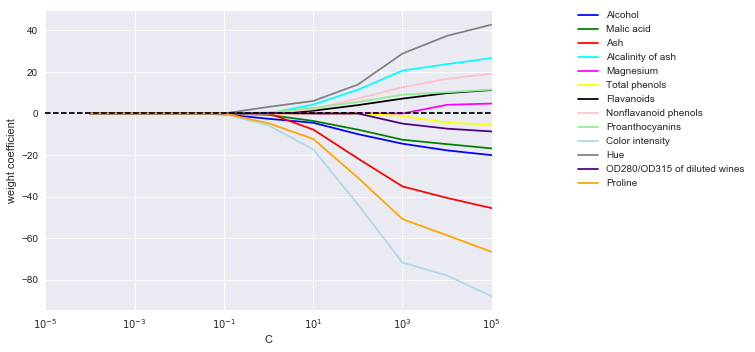

In [37]:
import matplotlib.pyplot as plt
import seaborn

fig = plt.figure()
ax = plt.subplot(111)   
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights = []
params = []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', 
                            C=10.**c, 
                            random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column+1],
             color=color)
plt.axhline(0, color='black', linestyle='--')
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

### Sequential Feature Selection Algorithms
次元削減の別手法として、Feature selection  Feature extraction がある。Feature selection とは学習データの一部を使用することで、Feature extraction とは学習データから新しい特徴量を導き出すことである。Sequential feature selection の中で Sequential Backward Selection (SBS)と呼ばれるアルゴリズムを本節で紹介する。SBS を使用することで次元削減による計算時間の短縮だけでなく、より精度の良い学習をできることもある。Feature extraction は第5章で説明する。

SBS アルゴリズムは、全特徴量を含む学習データから順次特徴量を除いてコスト関数をもとにどの特徴量を残すか決定する手順である。以下に1ステップずつ手順を示す。
1. 全特徴量を含む学習データを用意する。
1. 1つ特徴量を除いた学習データを使用したモデルの中で最もコスト関数の高い特徴量を見つける、すなわち最も予測精度に影響の与えない特徴量を見つける。
1. 前ステップで見つけた特徴量を除いた学習データを用意する。
1. 特徴量の数が目的の数まで減ったら終了する。減っていなかったらステップ2に戻る。

scikit-learn には SBS アルゴリズムは実装されていない。以下は SBS を実装したクラスのサンプルプログラム。

In [38]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score


class SBS():
    def __init__(self, estimator, k_features, 
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, 
                          X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    

上で定義した SBS クラスを KNN 分類器に適用する。

In [39]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=3)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

残した特徴量による学習データと予測精度の関係を見る。横軸が特徴量の数で、縦軸が予測精度。全特徴量を使用したとき、すなわち Number of features = 13 のときよりも 11 から 2 の方が精度が良くなっている。

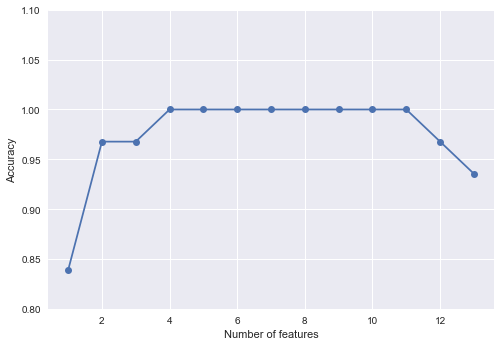

In [40]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.8, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

全特徴量を使用した学習データを使用した学習モデルの精度と、特徴量を6つ除いた学習データを使用した学習モデルの精度を計算すると、少ない特徴量でより良い予測ができていることが確認される。

In [41]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:',     knn.score(X_test_std,  y_test))

Training accuracy: 0.967741935484
Test accuracy: 0.981481481481


In [42]:
k5 = list(sbs.subsets_[6])
print(df_wine.columns[1:][k5])

knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:',     knn.score(X_test_std[:, k5],  y_test))

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Magnesium', 'Flavanoids',
       'Color intensity', 'Proline'],
      dtype='object')
Training accuracy: 0.983870967742
Test accuracy: 1.0


## Assessing Feature Importance with Random Forests
もう1つの特徴量抽出法は、第3章で紹介したランダムフォレストを使用する。ランダムフォレストアルゴリズムの中にFeature importanceという、特徴量が分類器に大きく影響を与えるほど大きくなる変数がある。Feature importanceが上位のみの特徴量を学習に利用する、すなわち次元削減する。
実際の利用方法は、sklearn の RandomForestClassifier クラス内にある feature_importances_ メソッドを呼び出すだけ。前述したように、Random Forest では正規化や標準化は必要とせずそのまま学習データを入力にして学習する。

In [43]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
rfc = RandomForestClassifier(n_estimators=2000,
                               random_state=0,
                               n_jobs=-1)
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[f], importances[indices[f]]))

 1) Alcohol                        0.183084
 2) Malic acid                     0.163305
 3) Ash                            0.152030
 4) Alcalinity of ash              0.133887
 5) Magnesium                      0.103847
 6) Total phenols                  0.077784
 7) Flavanoids                     0.058778
 8) Nonflavanoid phenols           0.031300
 9) Proanthocyanins                0.024420
10) Color intensity                0.021949
11) Hue                            0.021870
12) OD280/OD315 of diluted wines   0.014450
13) Proline                        0.013294


Feature importance は正規化されているので総和は1になる。

下図は Feature importance が高い順にプロットした棒グラフ。

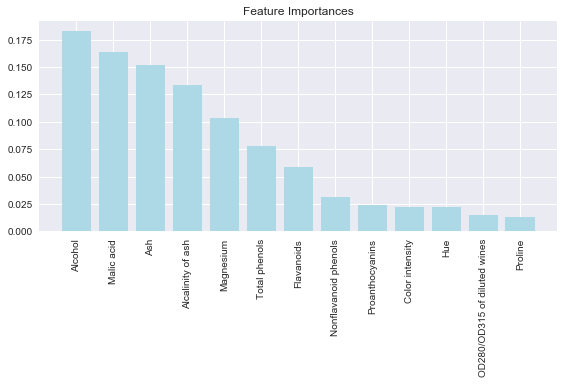

In [44]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Feature importance の値に応じてデータを取り出すにはオプション threshold を指定して transform メソッドを呼び出す。

In [45]:
X_selected = rfc.transform(X_train, threshold=0.15)
X_selected.shape

C:\Users\takashi\Anaconda2\envs\Python_ML\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(124, 3)